In [4]:
from thesispy.experiments.wandb_client import *
from thesispy.definitions import *
from thesispy.plot_utils import *
from thesispy.elastix_wrapper.parameters import Parameters
from thesispy.experiments.instance import read_controlpoints, read_transform_params
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

In [3]:
ds = get_runs_as_dataset("synthetic_1_fold_constraints")
ds.save()

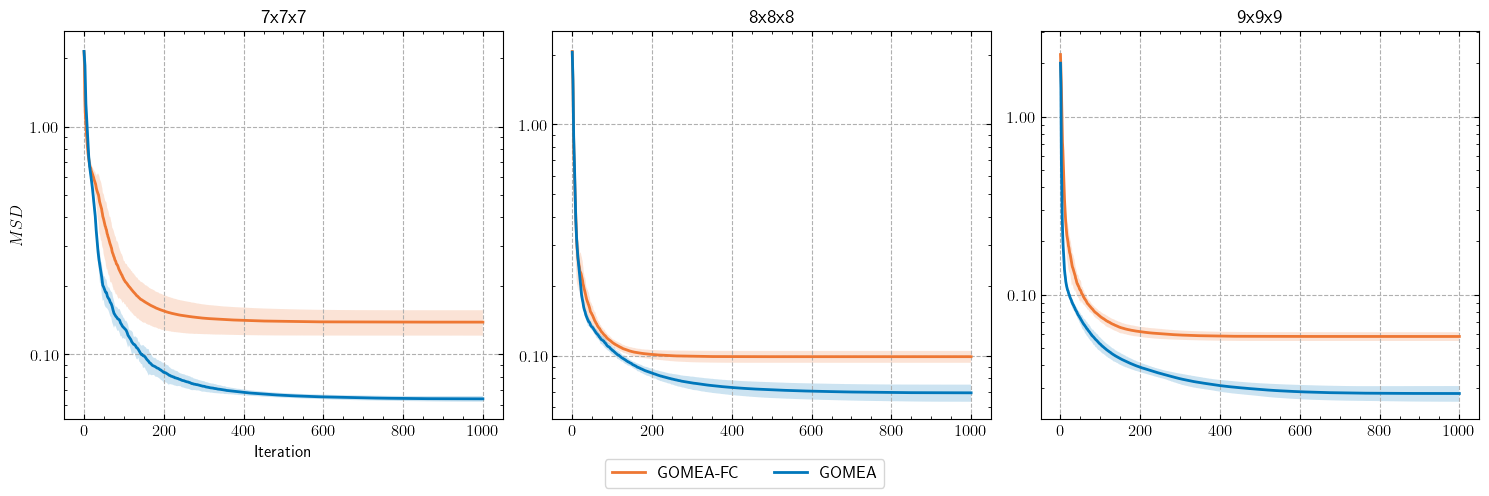

In [5]:
arrs = ds.aggregate_for_plot(["MeshSize", "ComputeControlPointFolds"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for i, mesh_size in enumerate([(4, 4, 4), (5, 5, 5), (6, 6, 6)]):
    for compute_folds in [True, False]:
        arr_avg, arr_median, arr_std = arrs[(mesh_size, compute_folds)]
        xs = np.linspace(0, 1000, len(arr_avg))
        label = "GOMEA-FC" if compute_folds else "GOMEA"
        axes[i].plot(xs, arr_avg, label=label)
        axes[i].fill_between(xs, arr_avg - arr_std, arr_avg + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].yaxis.set_major_formatter(formatter)
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center", fontsize=14)


axes[0].set_xlabel("Iteration", fontsize=12)
axes[0].set_ylabel("$MSD$", fontsize=12)
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower center", prop={'size': 12})

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("metric_values.pdf")

In [6]:
from thesispy.experiments.validation import validation_visualization, get_vmin_vmax

run_gomea = get_run_result("synthetic_1_fold_constraints", "2g3xmt9b")
run_gomea_fc = get_run_result("synthetic_1_fold_constraints", "2f28xrsy")

2023-03-16 12:58:49,888 - WandbClient - INFO - Retrieving run result from wandb: synthetic_1_fold_constraints/2g3xmt9b
2023-03-16 12:58:52,578 - WandbClient - INFO - Retrieving run result from wandb: synthetic_1_fold_constraints/2f28xrsy


In [7]:
clim_dvf, clim_jac = get_vmin_vmax(run_gomea, run_gomea_fc)

validation_visualization(run_gomea, clim_dvf=clim_dvf, clim_jac=clim_jac, tre=False)
plt.savefig("run_gomea.pdf", bbox_inches="tight")

2023-03-16 12:59:01,199 - Validation - INFO - Jacobian min,max: -5.569754226396456, 18.447006572019205
2023-03-16 12:59:01,201 - Validation - INFO - Jacobian min,max: 0.3587981241901111, 7.831388834288724
2023-03-16 12:59:02,544 - Validation - INFO - Jacobian min,max: -5.569754226396456, 18.447006572019205


In [8]:
validation_visualization(run_gomea_fc, clim_dvf=clim_dvf, clim_jac=clim_jac, tre=False)
plt.savefig("run_gomea_fc.pdf", bbox_inches="tight")

2023-03-16 12:59:28,945 - Validation - INFO - Jacobian min,max: 0.3587981241901111, 7.831388834288724


In [12]:
val_metrics = ["dvf_rmse", "tre", "mean_surface_cube", "mean_surface_sphere", "bending_energy"]
df_val = ds.aggregate(["MeshSize", "ComputeControlPointFolds"], val_metrics)

In [22]:
from scipy.stats import ttest_ind

mesh_sizes = [(4, 4, 4), (5, 5, 5), (6, 6, 6)]
compute_folds = [True, False]
for i, mesh_size in enumerate(mesh_sizes):
    print(f"Mesh size: {mesh_size}")
    baseline_str = ""
    constraints_str = ""
    for j, metric in enumerate(val_metrics):
        print(f"  Metric: {metric}")
        baseline_values = df_val.loc[(df_val.MeshSize == str(mesh_size)) & (df_val.ComputeControlPointFolds == "False")][metric].values
        constraint_values = df_val.loc[(df_val.MeshSize == str(mesh_size)) & (df_val.ComputeControlPointFolds == "True")][metric].values
        p_value = ttest_ind(baseline_values, constraint_values).pvalue

        print(f"    Baseline: ${baseline_values.mean():.2f} \pm {baseline_values.std():.2f}$")
        print(f"    Hybrid: ${constraint_values.mean():.2f} \pm {constraint_values.std():.2f}$")
        print(f"    P-value: {p_value:.2f}")

        if baseline_values.mean() < constraint_values.mean() and p_value < 0.05:
            baseline_str += f"$\\textbf{{{baseline_values.mean():.2f} \pm {baseline_values.std():.2f}}}$ & "
            constraints_str += f"${constraint_values.mean():.2f} \pm {constraint_values.std():.2f}$ & "
        elif baseline_values.mean() > constraint_values.mean() and p_value < 0.05:
            baseline_str += f"${baseline_values.mean():.2f} \pm {baseline_values.std():.2f}$ & "
            constraints_str += f"$\\textbf{{{constraint_values.mean():.2f} \pm {constraint_values.std():.2f}}}$ & "
        else:
            baseline_str += f"${baseline_values.mean():.2f} \pm {baseline_values.std():.2f}$ & "
            constraints_str += f"${constraint_values.mean():.2f} \pm {constraint_values.std():.2f}$ & "
    print(baseline_str)
    print(constraints_str)

Mesh size: (4, 4, 4)
  Metric: dvf_rmse
    Baseline: $0.77 \pm 0.24$
    Hybrid: $1.24 \pm 0.04$
    P-value: 0.00
  Metric: tre
    Baseline: $1.89 \pm 0.59$
    Hybrid: $2.80 \pm 0.07$
    P-value: 0.00
  Metric: mean_surface_cube
    Baseline: $0.42 \pm 0.02$
    Hybrid: $0.40 \pm 0.01$
    P-value: 0.01
  Metric: mean_surface_sphere
    Baseline: $0.28 \pm 0.01$
    Hybrid: $0.44 \pm 0.04$
    P-value: 0.00
  Metric: bending_energy
    Baseline: $0.57 \pm 0.27$
    Hybrid: $0.38 \pm 0.04$
    P-value: 0.05
$\textbf{0.77 \pm 0.24}$ & $\textbf{1.89 \pm 0.59}$ & $0.42 \pm 0.02$ & $\textbf{0.28 \pm 0.01}$ & $0.57 \pm 0.27$ & 
$1.24 \pm 0.04$ & $2.80 \pm 0.07$ & $\textbf{0.40 \pm 0.01}$ & $0.44 \pm 0.04$ & $0.38 \pm 0.04$ & 
Mesh size: (5, 5, 5)
  Metric: dvf_rmse
    Baseline: $0.84 \pm 0.04$
    Hybrid: $0.34 \pm 0.06$
    P-value: 0.00
  Metric: tre
    Baseline: $1.96 \pm 0.08$
    Hybrid: $0.80 \pm 0.12$
    P-value: 0.00
  Metric: mean_surface_cube
    Baseline: $0.58 \pm 0.02$
 

In [19]:
df_val.loc[(df_val.MeshSize == str((4,4,4))) & (df_val.ComputeControlPointFolds == "True")]

,dvf_rmse,tre,mean_surface_cube,mean_surface_sphere,bending_energy,MeshSize,ComputeControlPointFolds
0,1.238725,2.766541,0.407224,0.407213,0.412032,"(4, 4, 4)",True
0,1.280079,2.945687,0.394905,0.373628,0.399118,"(4, 4, 4)",True
0,1.181446,2.749195,0.375054,0.454963,0.299501,"(4, 4, 4)",True
0,1.263476,2.831303,0.408181,0.483711,0.388669,"(4, 4, 4)",True
0,1.225025,2.694965,0.397946,0.460379,0.409269,"(4, 4, 4)",True
0,1.255892,2.800158,0.390194,0.389206,0.389574,"(4, 4, 4)",True
0,1.162727,2.743703,0.395525,0.453463,0.288812,"(4, 4, 4)",True
0,1.262070,2.829654,0.407686,0.468276,0.403389,"(4, 4, 4)",True
0,1.243974,2.839652,0.404721,0.459566,0.392345,"(4, 4, 4)",True
0,1.241484,2.798834,0.402919,0.461146,0.368712,"(4, 4, 4)",True
